<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj25-cv-camvid-semantic-segmentation?scriptVersionId=194501565" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>CAMvid semantic segmentation</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project aims to utilize the Cambridge-driving Labeled Video Database (CamVid) for real-time semantic segmentation research. By analyzing pixel-level ground truth labels across 32 semantic classes, the goal is to develop advanced segmentation models that can accurately classify and segment various elements in driving scenes. This work contributes to the broader field of autonomous driving and real-time image processing.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Dropout , Flatten , Input
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121

In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras

In [4]:
!kaggle datasets download -d carlolepelaars/camvid
!unzip camvid.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid
License(s): CC-BY-NC-SA-4.0
 98%|████████████████████████████████████████ | 561M/575M [00:04<00:00, 126MB/s]
100%|█████████████████████████████████████████| 575M/575M [00:04<00:00, 137MB/s]


# **Data Exploration**
----

In [5]:
print('Number of train frames: ' + str(len(os.listdir('CamVid/train'))))
print('Number of train labels: ' + str(len(os.listdir('CamVid/train_labels'))))
print('Number of val frames: ' + str(len(os.listdir('CamVid/val'))))
print('Number of val labels: ' + str(len(os.listdir('CamVid/val_labels'))))
print('Number of test frames: ' + str(len(os.listdir('CamVid/test'))))
print('Number of test labels: ' + str(len(os.listdir('CamVid/test_labels'))))
print('Total frames: ' + str(len(os.listdir('CamVid/train')) + len(os.listdir('CamVid/val')) + len(os.listdir('CamVid/test'))))

Number of train frames: 369
Number of train labels: 369
Number of val frames: 100
Number of val labels: 100
Number of test frames: 232
Number of test labels: 232
Total frames: 701


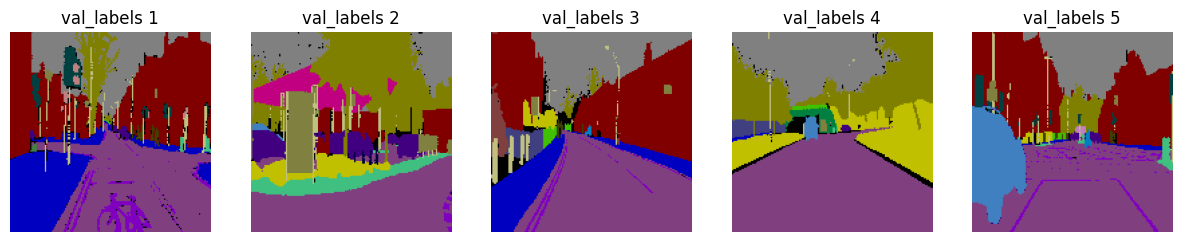

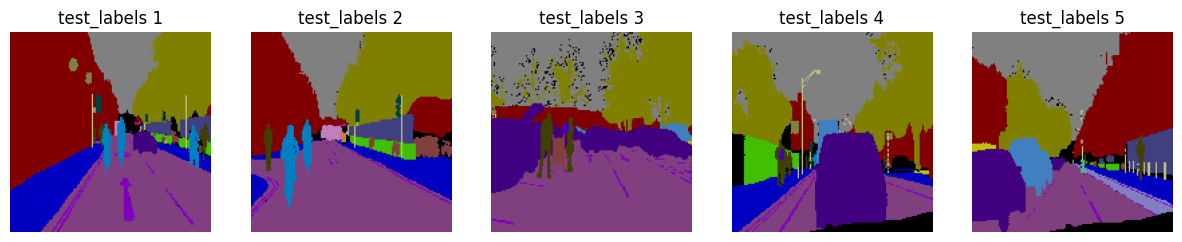

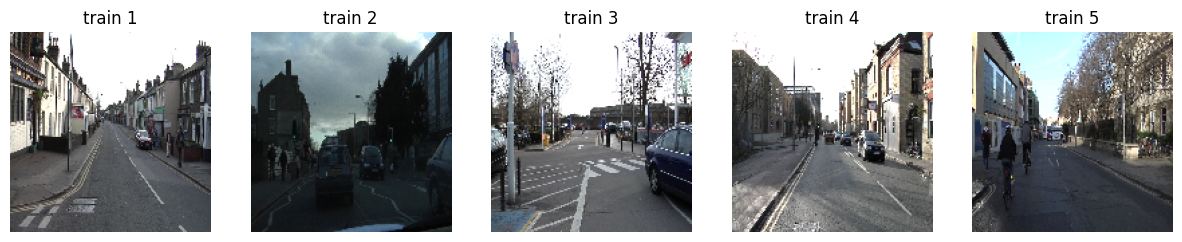

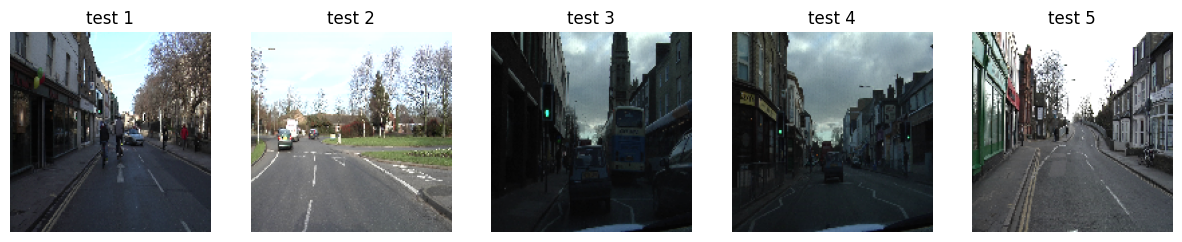

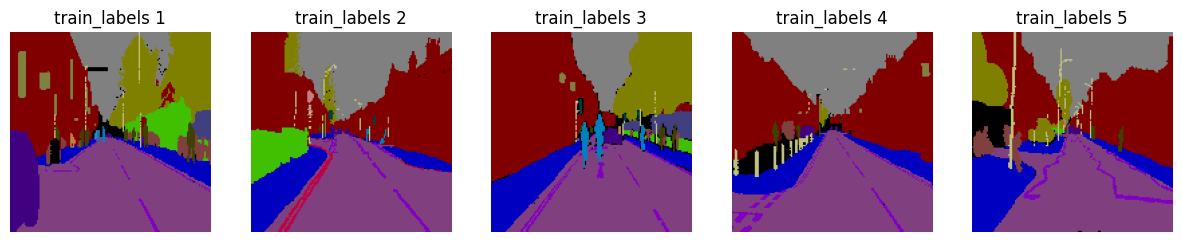

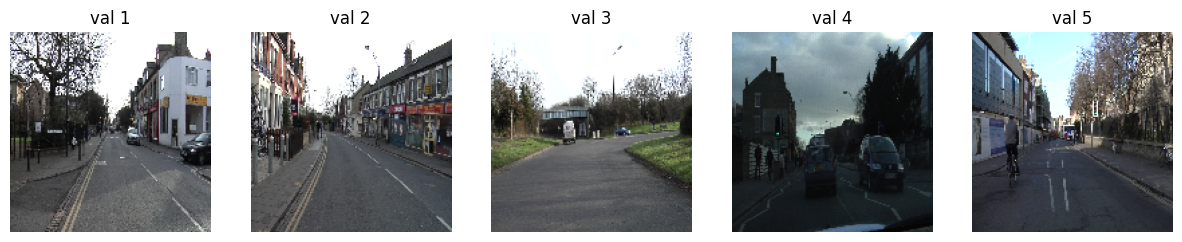

In [6]:
def display_images_by_class(parent_folder, n_images=5):
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

parent_folder = 'CamVid'

display_images_by_class(parent_folder, n_images=5)

# **Data Preparation**
----

**create a map from class name to color**

In [7]:
classes = pd.read_csv('CamVid/class_dict.csv')
print('Num of classes = ' , len(classes))
classes

Num of classes =  32


,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [8]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
cls2rgb

{0: ['Animal', 64, 128, 64],
 1: ['Archway', 192, 0, 128],
 2: ['Bicyclist', 0, 128, 192],
 3: ['Bridge', 0, 128, 64],
 4: ['Building', 128, 0, 0],
 5: ['Car', 64, 0, 128],
 6: ['CartLuggagePram', 64, 0, 192],
 7: ['Child', 192, 128, 64],
 8: ['Column_Pole', 192, 192, 128],
 9: ['Fence', 64, 64, 128],
 10: ['LaneMkgsDriv', 128, 0, 192],
 11: ['LaneMkgsNonDriv', 192, 0, 64],
 12: ['Misc_Text', 128, 128, 64],
 13: ['MotorcycleScooter', 192, 0, 192],
 14: ['OtherMoving', 128, 64, 64],
 15: ['ParkingBlock', 64, 192, 128],
 16: ['Pedestrian', 64, 64, 0],
 17: ['Road', 128, 64, 128],
 18: ['RoadShoulder', 128, 128, 192],
 19: ['Sidewalk', 0, 0, 192],
 20: ['SignSymbol', 192, 128, 128],
 21: ['Sky', 128, 128, 128],
 22: ['SUVPickupTruck', 64, 128, 192],
 23: ['TrafficCone', 0, 0, 64],
 24: ['TrafficLight', 0, 64, 64],
 25: ['Train', 192, 64, 128],
 26: ['Tree', 128, 128, 0],
 27: ['Truck_Bus', 192, 128, 192],
 28: ['Tunnel', 64, 0, 64],
 29: ['VegetationMisc', 192, 192, 0],
 30: ['Void', 0, 0

# **Masks labels adjustment**
----

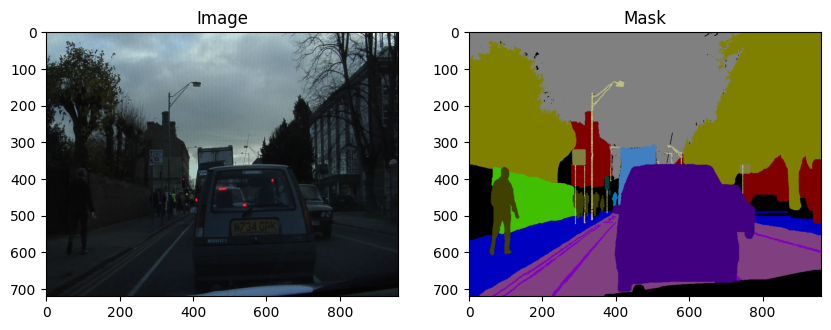

In [9]:
img = load_img('CamVid/train/0001TP_009210.png')
mask = load_img('CamVid/train_labels/0001TP_009210_L.png')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [10]:
mask = np.array(mask)
mask.shape

(720, 960, 3)

In [11]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for value in cls2rgb.values():
        # Extract only the RGB values (e.g., [64, 128, 64])
        colour = value[1:]  # Skip the class name
        colour_array = np.array(colour, dtype=np.uint8)  # Convert to uint8 array
        equality = np.equal(mask, colour_array)  # Compare mask with colour
        class_map = np.all(equality, axis=-1)  # 256x256 If all True, then True, else False
        semantic_map.append(class_map)  # Append 256x256 array

    semantic_map = np.stack(semantic_map, axis=-1)  # 256x256xN (N is the number of classes)

    if flat:
        semantic_map = np.reshape(semantic_map, (-1, 256*256))

    return np.float32(semantic_map)  # Convert to float32


In [12]:
new_mask = adjust_mask(mask)
new_mask.shape

(720, 960, 32)

Map the idx back to rgb to make sure everything is correct

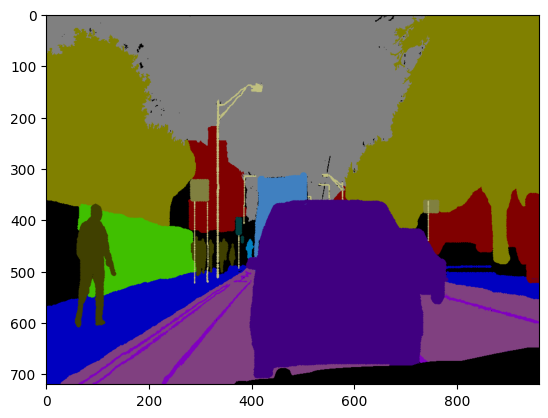

In [13]:
idx2rgb={idx:np.array(rgb[1:], dtype=np.uint8) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
# Only store RGB values as uint8 in idx2rgb

def map_class_to_rgb(p):
  return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))
plt.imshow(rgb_mask)
plt.show()

# **Load Data**
----

In [14]:
batch_sz = 4
n_classes = 32
data_path = 'CamVid'

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation parameters for images and masks
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

# Image and Mask Data Generators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args)

In [16]:
test_data_gen_args = dict(rescale=1./255)
mask_data_gen_args = dict()

# Image and Mask Data Generators for Testing
test_image_datagen = ImageDataGenerator(**test_data_gen_args)
test_mask_datagen = ImageDataGenerator(**mask_data_gen_args)

In [17]:

# Seed to ensure the same transformation for image and mask
seed = 1

# Training generators
image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['train'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['train_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():
    for (img, mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img, new_mask)

Found 369 images belonging to 1 classes.
Found 369 images belonging to 1 classes.


In [18]:
# Validation generators
val_image_generator = image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['val'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256))

val_mask_generator = mask_datagen.flow_from_directory(
    data_path,
    classes=['val_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256))

# Combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)

def val_generator_fn():
    for (img, mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img, new_mask)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [19]:
# Test image generator
test_image_generator = test_image_datagen.flow_from_directory(
    data_path,
    class_mode=None,
    classes=['test'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256, 256))

# Test mask generator
test_mask_generator = test_mask_datagen.flow_from_directory(
    data_path,
    classes=['test_labels'],
    class_mode=None,
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256, 256))

# Combine generators into one, which yields image and mask pairs
test_generator = zip(test_image_generator, test_mask_generator)

def test_generator_fn():
    for img, mask in test_generator:
        new_mask = adjust_mask(mask)
        yield (img, new_mask)

Found 232 images belonging to 1 classes.
Found 232 images belonging to 1 classes.


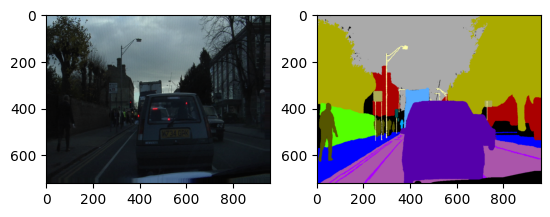

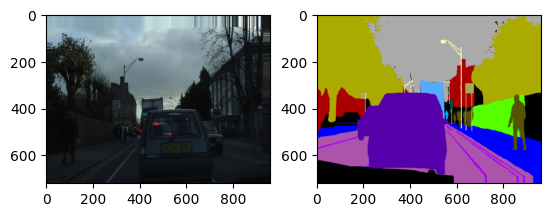

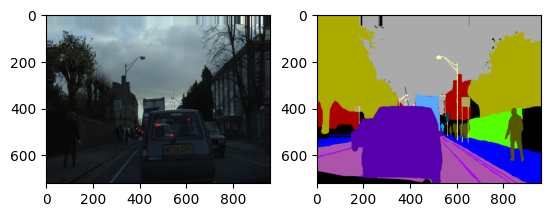

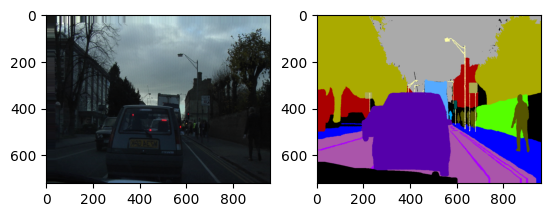

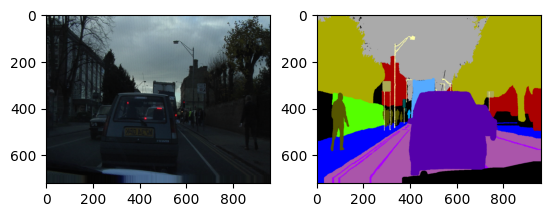

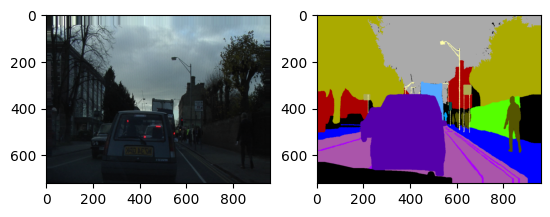

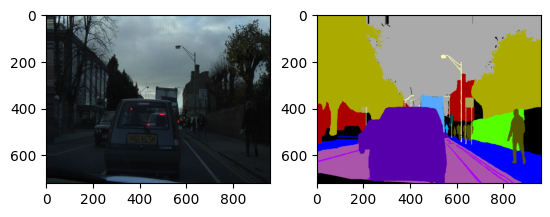

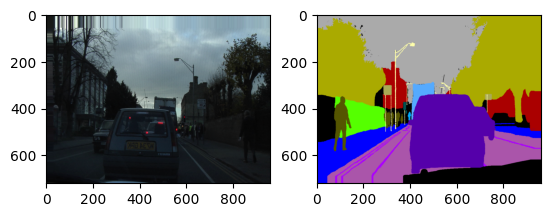

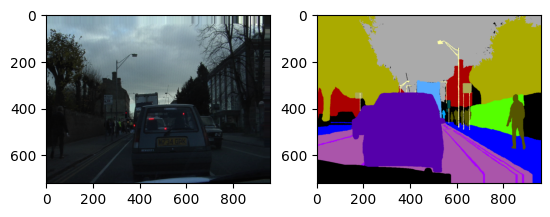

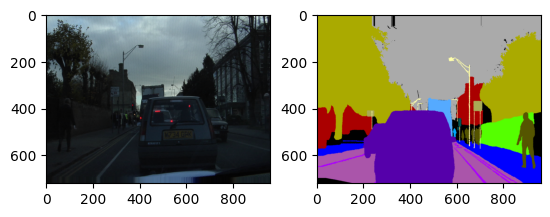

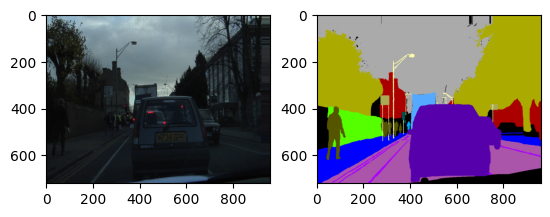

In [20]:
from keras.preprocessing.image import array_to_img, img_to_array
i = 0
img = img_to_array(img)
mask = img_to_array(mask)
for aug_img, aug_mask in zip(image_datagen.flow(np.expand_dims(img, 0), batch_size=1), mask_datagen.flow(np.expand_dims(mask, 0), batch_size=1)):
    plt.figure(i)
    plt.subplot(221)
    imgplot = plt.imshow(array_to_img(aug_img[0]))
    plt.subplot(222)
    imgplot = plt.imshow(array_to_img(aug_mask[0]))
    i += 1
    if i > 10:
        break

plt.show()

# **Modeling**
----

In [21]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y
def Unet(h, w, filters, num_classes = 32):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [22]:
model = Unet(256 , 256 , 64)
model.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 34,538,912 (131.76 MB)

 Trainable params: 34,527,136 (131.71 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
ES = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [25]:
history = model.fit(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=len(image_generator),
                    validation_steps=len(val_image_generator),
                    epochs=2,
                    batch_size=4,
                    callbacks=[ES,RL])

Epoch 1/2


I0000 00:00:1724905184.550669     125 service.cc:145] XLA service 0x7b24ac002810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724905184.550737     125 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/93 ━━━━━━━━━━━━━━━━━━━━ 1:02:23 41s/step - accuracy: 0.0166 - loss: 3.3963

I0000 00:00:1724905211.484576     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 126s 931ms/step - accuracy: 0.5119 - loss: 1.6752 - val_accuracy: 0.0710 - val_loss: 12.7522 - learning_rate: 0.0010
Epoch 2/2
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 713ms/step - accuracy: 0.6533 - loss: 0.9172 - val_accuracy: 0.4821 - val_loss: 1.9251 - learning_rate: 0.0010


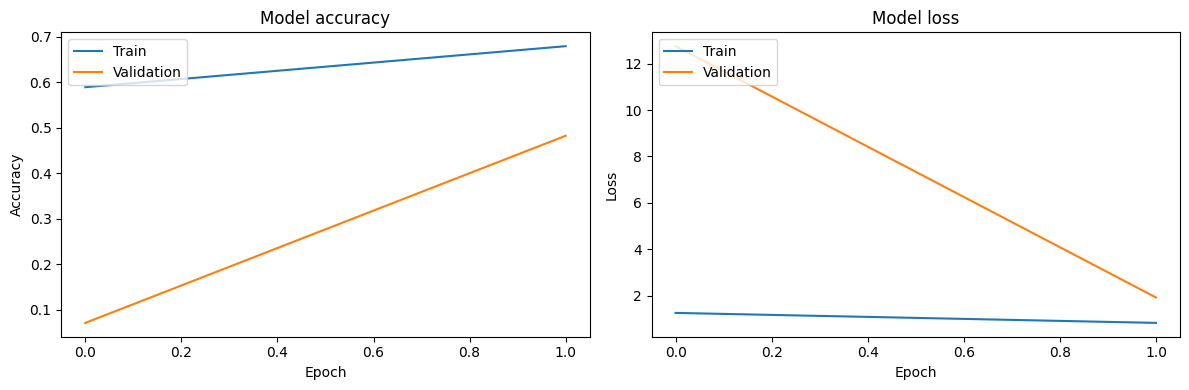

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Prediction**
----

In [27]:
loss, acc = model.evaluate(train_generator_fn(), steps=100, batch_size=128, verbose=0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss, acc = model.evaluate(test_generator_fn(), steps=100, batch_size=128, verbose=0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

The accuracy of the model for training data is: 47.601211071014404
The Loss of the model for training data is: 1.9245526790618896
The accuracy of the model for test data is: 45.85291147232056
The Loss of the model for test data is: 2.3787190914154053


**Display Some Images With Predictions**

In [28]:
def visualize_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
  plt.figure(figsize=(12, 8))
  
  # Img
  plt.subplot(311)    
  plt.imshow(img)
  plt.title('Original Image')
  plt.axis('off')
  
  # Predict
  pred_mask = model.predict(np.expand_dims(img, 0))
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0]
  if shape=='flat':
    pred_mask = np.reshape(pred_mask, (256,256)) # Reshape only if you use the flat model. O.w. you dont need
  
  rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
  
  # Prediction
  plt.subplot(312)
  plt.imshow(rgb_mask)
  plt.title('Predicted Mask')
  plt.axis('off')
              
  # GT mask
  if gt_mode == 'ohe':
    gt_img_ohe = np.argmax(gt_mask, axis=-1)
    gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))              
  
  plt.subplot(313)
  plt.imshow((gt_mask).astype(np.uint8))
  plt.title('Ground Truth Mask')
  plt.axis('off')
    
  plt.tight_layout()
  plt.show()            

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


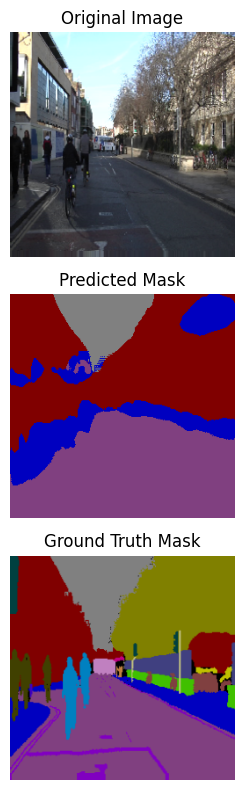

In [29]:
img = next(image_generator)[0]
gt_img = next(mask_generator)[0]
visualize_seg(img, gt_img, gt_mode='sparse')